In [3]:
import numpy as np
import abcd_graph
import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score as ARI

import networkx as nx
import partition_networkx
import community

import igraph as ig
import partition_igraph

import sknetwork as sn
import partition_sknetwork as ps

import random
random.seed(42)
np.random.seed(42)

## Performance Evaluation

We evaluate the performance of each ecg implementation, and compare to Louvain.
Our evalation metrics are the Adjusted Rand Index (ARI) and Graph Aware Adjusted Rand Index (AGRI).
We use synthetic *Artificial Benchmark for Community Detection (ABCD)* graphs, which are similar to *LFR*, but when noise=1 we get no communities instead of anti-communities.

Bogumił Kamiński, Paweł Prałat and François Théberge. Artificial Benchmark for Community Detection (ABCD)—Fast random graph model with community structure. Network Science. 2021;9(2):153-178. https://doi.org/10.1017/nws.2020.45

In [4]:
xis = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
n_runs = 25
aris = np.empty((4, len(xis), n_runs))
agris = np.empty_like(aris)

with tqdm.tqdm(total=len(xis)*n_runs) as pbar:
    for xi_index, xi in enumerate(xis):
        for run in range(n_runs):
            params = abcd_graph.ABCDParams(1000, xi=xi, max_degree=50)
            abcd = abcd_graph.ABCDGraph(params).build()
            labels = np.array([i for i, com in enumerate(abcd.communities) for _ in com.vertices])
            set_labels = [set(com.vertices) for com in abcd.communities]  # networkx and igraph gam use this format

            # networkx
            graph = abcd.exporter.to_networkx()
            ecg = community.ecg(graph, ens_size=16, resolution=1.0)
            aris[0, xi_index, run] = ARI(list(ecg.partition.values()), labels)
            agris[0, xi_index, run] = graph.gam(ecg.partition, set_labels)

            # igraph
            graph = abcd.exporter.to_igraph()
            ecg = graph.community_ecg()
            aris[1, xi_index, run] = ARI(ecg.membership, labels)
            agris[1, xi_index, run] = graph.gam(ecg, set_labels)

            # sknetwork
            graph = abcd.exporter.to_sparse_adjacency_matrix()
            ecg = ps.ECG(final='louvain').fit_predict(graph)
            aris[2, xi_index, run] = ARI(ecg, labels)
            agris[2, xi_index, run] = ps.gam(graph, ecg, labels)

            # sknetwork louvain for comparison
            louvain = sn.clustering.Louvain().fit_predict(graph)
            aris[3, xi_index, run] = ARI(louvain, labels)
            agris[3, xi_index, run] = ps.gam(graph, louvain, labels)

            pbar.update()




100%|██████████| 175/175 [05:11<00:00,  1.78s/it]


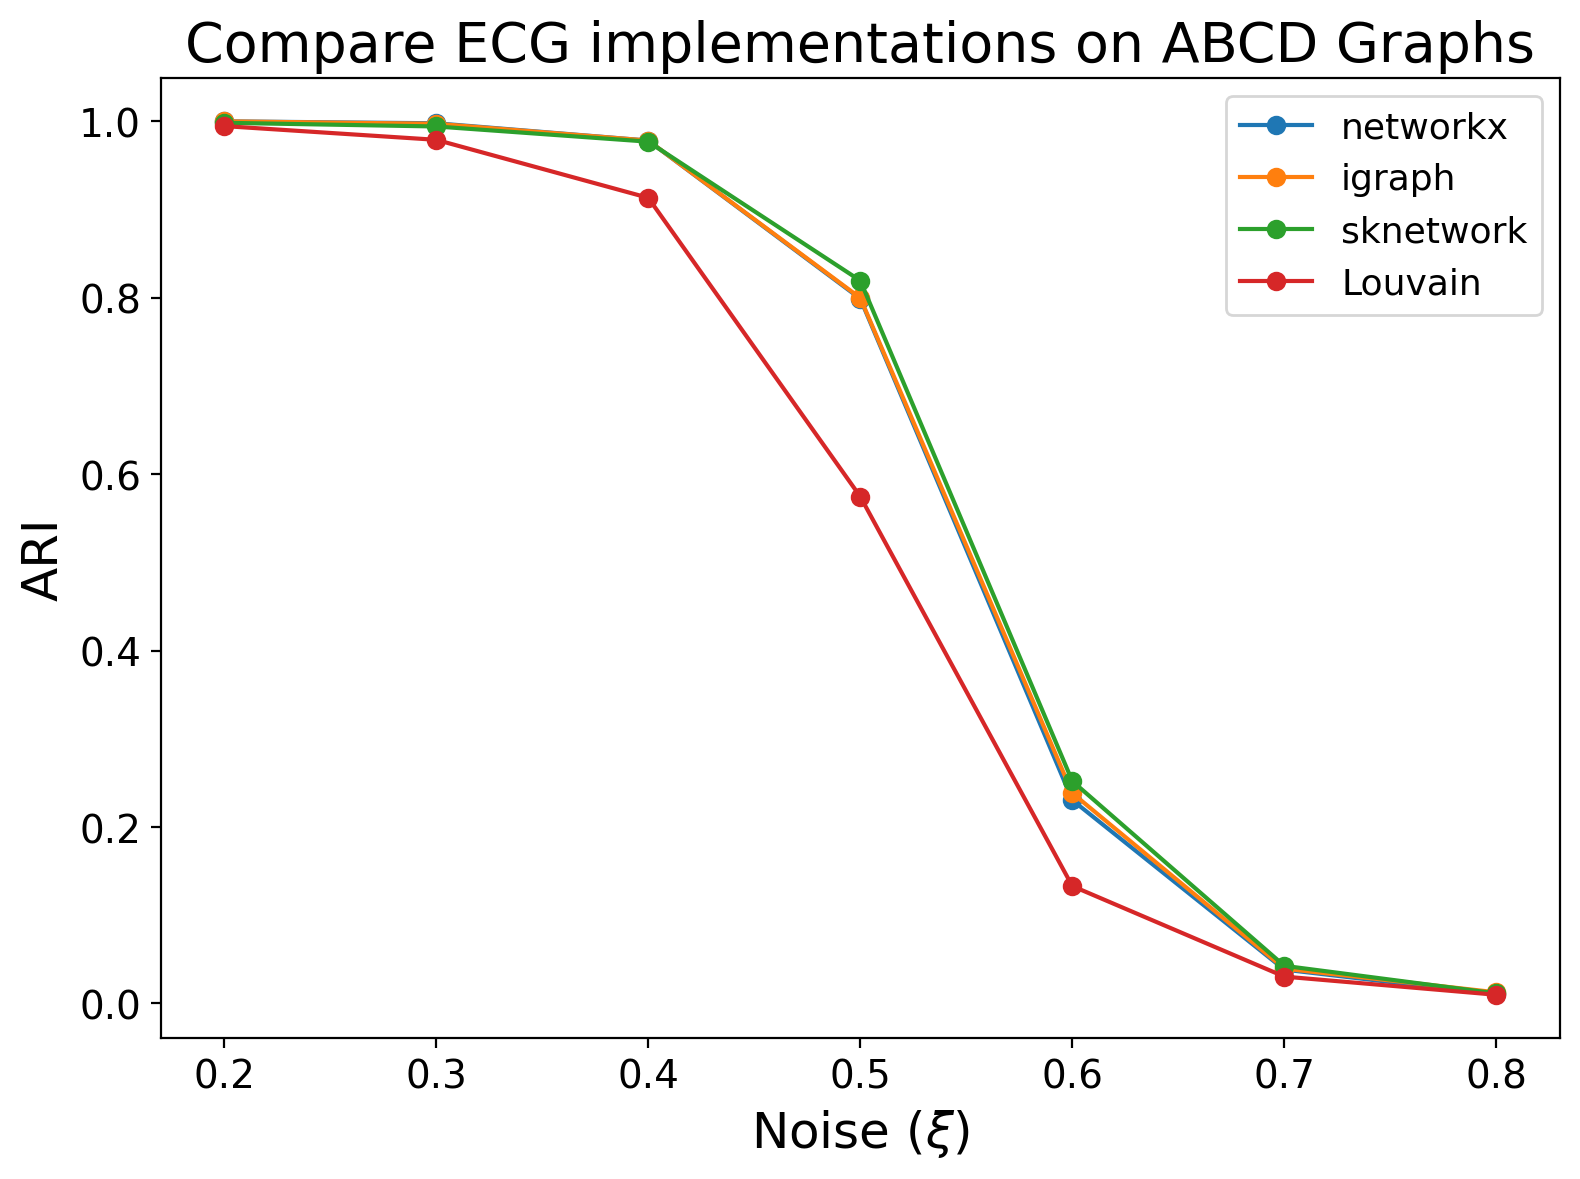

In [5]:
avg = np.mean(aris, axis=2)
plt.figure(figsize=(8, 6), dpi=200)
plt.plot(xis, avg[0, :], 'o-',label="networkx")
plt.plot(xis, avg[1, :], 'o-',label="igraph")
plt.plot(xis, avg[2, :], 'o-',label="sknetwork")
plt.plot(xis, avg[3, :], 'o-', label="Louvain")
plt.legend(fontsize=13)
plt.title("Compare ECG implementations on ABCD Graphs", fontsize=20)
plt.xlabel(r"Noise ($\xi$)", fontsize=18)
plt.ylabel("ARI", fontsize=18)
plt.tick_params(labelsize=14)
plt.tight_layout()

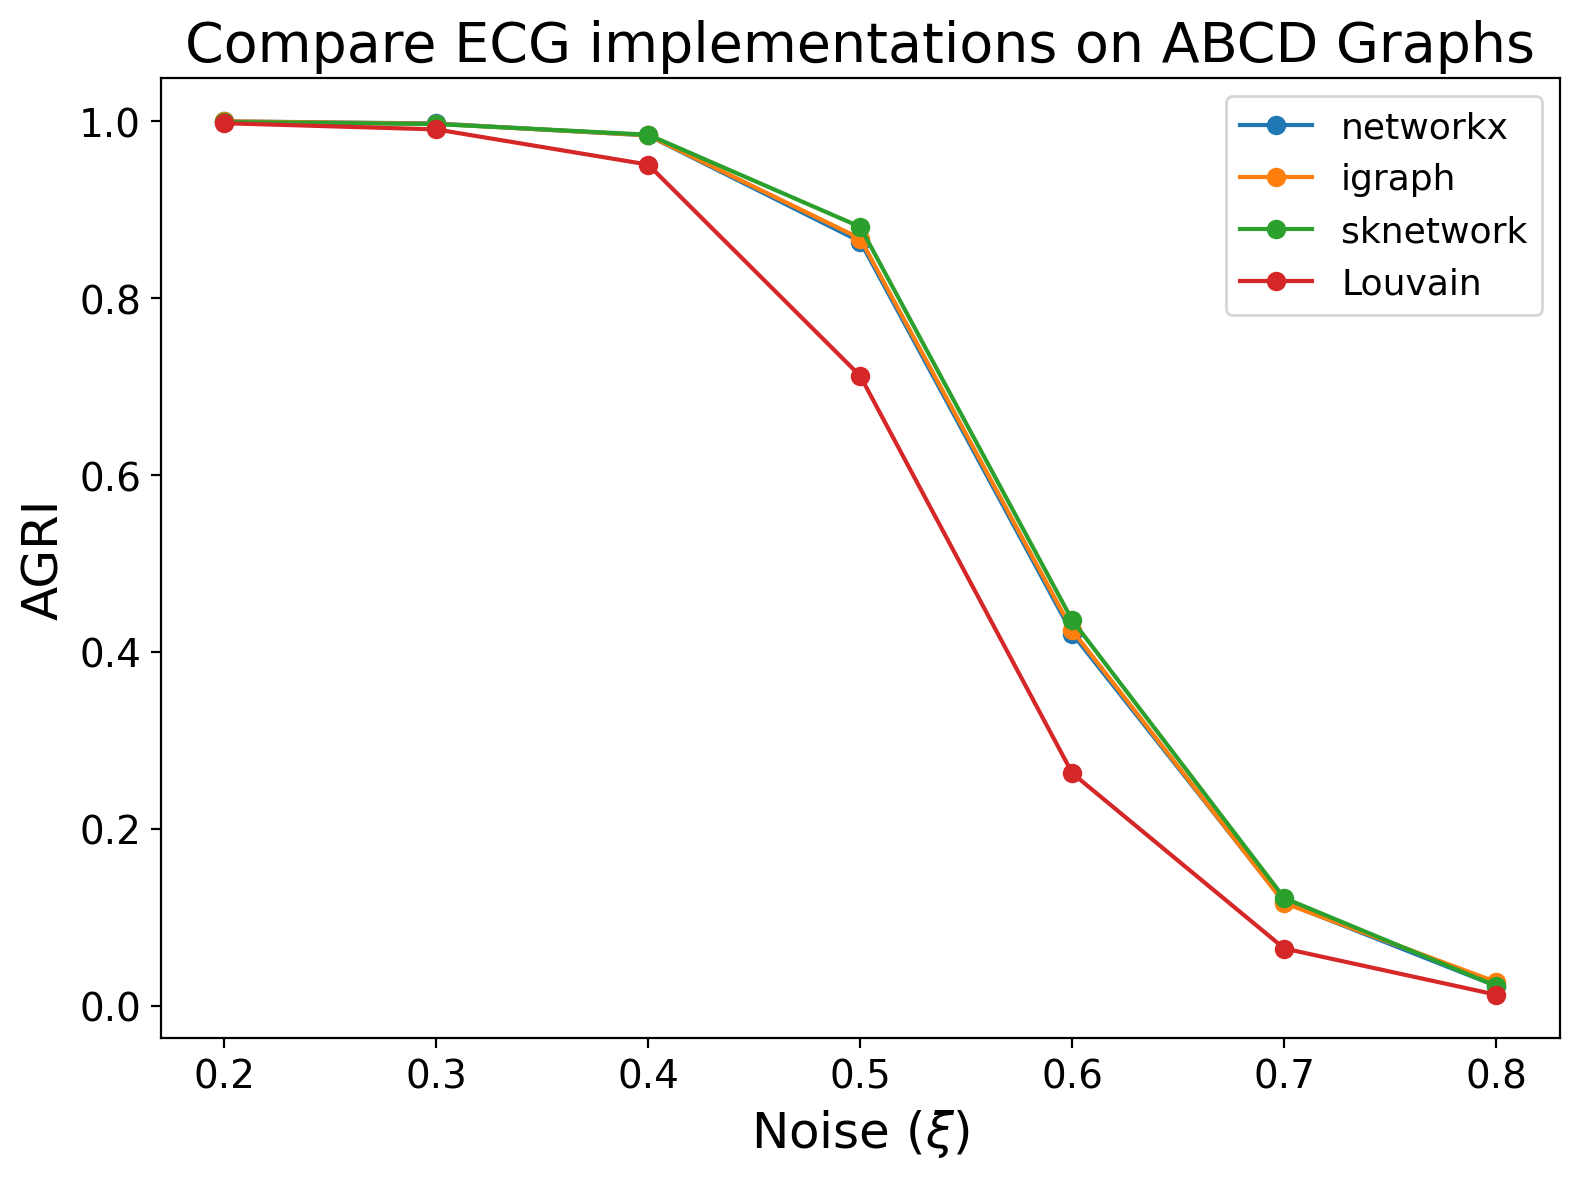

In [6]:
avg = np.mean(agris, axis=2)
plt.figure(figsize=(8, 6), dpi=200)
plt.plot(xis, avg[0, :], 'o-',label="networkx")
plt.plot(xis, avg[1, :], 'o-',label="igraph")
plt.plot(xis, avg[2, :], 'o-',label="sknetwork")
plt.plot(xis, avg[3, :], 'o-', label="Louvain")
plt.legend(fontsize=13)
plt.title("Compare ECG implementations on ABCD Graphs", fontsize=20)
plt.xlabel(r"Noise ($\xi$)", fontsize=18)
plt.ylabel("AGRI", fontsize=18)
plt.tick_params(labelsize=14)
plt.tight_layout()

## Speed test

Test the run time of each method on a graph with 10,000 nodes.

In [7]:
params = abcd_graph.ABCDParams(10000, xi=0.4, max_degree=100)
abcd = abcd_graph.ABCDGraph(params).build()

nx_graph = abcd.exporter.to_networkx()
ig_graph = abcd.exporter.to_igraph()
sn_graph = abcd.exporter.to_sparse_adjacency_matrix()

In [8]:
%%timeit
community.ecg(nx_graph)

15.6 s ± 505 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%%timeit
ig_graph.community_ecg()

1.1 s ± 13.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%%timeit
ps.ECG(final='louvain').fit_predict(sn_graph)

774 ms ± 7.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
